In [89]:
import warnings

warnings.simplefilter(action='ignore', category=RuntimeWarning)

import torch
import numpy as np
from statsmodels.stats.proportion import binom_test, proportion_confint
from communityaware.cert.anisotropic import anisotropic
from communityaware.cert.isotropic import isotropic
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from matplotlib import cm
import matplotlib as mpl
import pandas as pd
import networkx as nx
from matplotlib import ticker
from tqdm import tqdm
from functools import lru_cache
import scipy

sns.set_context('paper')
colour_cmap = mpl.colormaps['Greens']
grey_cmap = mpl.colormaps['Greens']

# Settings

In [90]:
kernel = 'vh'
confidence_level = 0.99
motif_n = 10
random_n = 10
train_n = 1000
valid_n = 1000
test_n = 100

# Training information

In [91]:
fname = f'{kernel}_{motif_n}_{random_n}_{train_n}_{valid_n}_{test_n}'
training_info = pickle.load(open(f'../output/kernel/{fname}.pkl', 'rb'))
print('Train accuracy', training_info['train_accuracy'])
print('Valid accuracy', training_info['valid_accuracy'])
print('Test accuracy', training_info['test_accuracy'])

Train accuracy 1.0
Valid accuracy 1.0
Test accuracy 1.0


In [92]:
fname = f'{motif_n}_{random_n}_{train_n}_{valid_n}_{test_n}'
data = pickle.load(open(f'../data/kernel/{fname}.pkl', 'rb'))
y_test = data['y_test']
G_test = data['G_test']

# Graph plots

In [93]:
def grakel_to_networkx(graph):
    graph_nx = nx.Graph()
    nodes = list(graph[0].keys())
    graph_nx.add_nodes_from(nodes)
    for u in nodes:
        graph_nx.add_edges_from([(u, v) for v in graph[0][u].keys()])
    return graph_nx

def nodecolours(graph, main_colour, second_colour):
    node_colours = []
    for node in graph.nodes():
        if node < motif_n:
            node_colours.append(main_colour)
        else:
            node_colours.append(second_colour)
    return node_colours

def edgecolours(graph, main_colour, second_colour):
    edge_colours = []
    for edge in graph.edges():
        if edge[0] < motif_n and edge[1] < motif_n:
            edge_colours.append(main_colour)
        else:
            edge_colours.append(second_colour)
    return edge_colours

def rotate_vector(x, midpoint, degrees):
    x = x - midpoint
    theta = np.radians(degrees)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    return (R @ x) + midpoint

blue = [0, 0.4470, 0.7410]
red = [0.8500, 0.3250, 0.0980]
grey = [0.5, 0.5, 0.5]

graph_0 = grakel_to_networkx(G_test[np.where(y_test==0)[0][0]])
graph_1 = grakel_to_networkx(G_test[np.where(y_test==1)[0][0]])

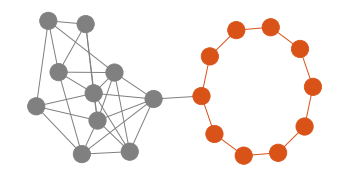

In [94]:
pos = nx.spring_layout(graph_0, seed=0)
pos = {key: rotate_vector(value, np.mean(list(pos.values()), axis=0), -90) for key, value in pos.items()}

# motif 
circle_pos = nx.circular_layout(nx.path_graph(motif_n))
anchor = (0.4, np.mean([pos[i] for i in range(motif_n, motif_n+random_n)], axis=0)[1])
circle_pos = {key: 0.2*value + anchor for key, value in circle_pos.items()}
circle_pos = {key: rotate_vector(value, np.mean(list(circle_pos.values()), axis=0), 220) for key, value in circle_pos.items()}
pos.update(circle_pos)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
nx.draw_networkx_nodes(graph_0, pos=pos, node_color=nodecolours(graph_0, red, grey), ax=ax)
nx.draw_networkx_edges(graph_0, pos=pos, edge_color=edgecolours(graph_0, red, grey), ax=ax)
ax.axis('off')
fig.savefig('../figures/graph_0.eps', format='eps', bbox_inches='tight')

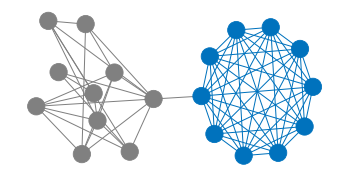

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
nx.draw_networkx_nodes(graph_1, pos=pos, node_color=nodecolours(graph_1, blue, grey), ax=ax)
nx.draw_networkx_edges(graph_1, pos=pos, edge_color=edgecolours(graph_1, blue, grey), ax=ax)
ax.axis('off')
fig.savefig('../figures/graph_1.eps', format='eps', bbox_inches='tight')

# Noise matrix 

In [96]:
number_of_nodes = motif_n + random_n
p1 = 0.3
p2 = 0.45

noise_matrix = np.zeros((number_of_nodes, number_of_nodes))
for i in range(motif_n):
    for j in range(i+1, motif_n):
        if i == 0 and j == motif_n-1:
            continue
        elif i == j - 1:
            continue
        else:
            noise_matrix[i, j] = p1

noise_matrix = noise_matrix + noise_matrix.T
noise_matrix[motif_n:, motif_n:] = p2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


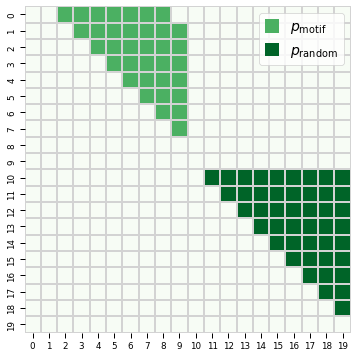

In [97]:
np.fill_diagonal(noise_matrix, 0.0)
noise_matrix = np.triu(noise_matrix)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(noise_matrix, square=True, cmap=grey_cmap, linewidths=0.01, cbar=False, ax=ax, vmin=0, vmax=0.5, linecolor='lightgrey', linestyle='dashed')


plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
custom_lines = [plt.Rectangle((0,0), height=20, width=20, linewidth=0, color=grey_cmap(0.3*2)),
                plt.Rectangle((0,0), height=20, width=20, linewidth=0, color=grey_cmap(0.45*2))]
ax.legend(custom_lines, ['$p_\mathregular{motif}$', r'$p_\mathregular{random}$'], fontsize=14)
fig.savefig('../figures/noise_matrix.eps', format='eps', bbox_inches='tight')

# Volume and accuracy for different P

In [98]:
def certificate_grid(p_A, P, max_R):
    grid = np.zeros(max_R)
    for i in range(max_R[0]):
        for j in range(max_R[1]):
            if i == 0 and j == 0:
                grid[i][j] = p_A
            else:
                grid[i][j] = float(anisotropic(R=(i, j), P=P, p_A=p_A))
    return grid

@lru_cache()
def evaluate_P(P, max_R=(8, 8)):
    votes = torch.load(f'../output/kernel/votes/{P[0]}_{P[1]}_{kernel}').numpy()
    p_A = proportion_confint(votes.max(1), votes.sum(1), alpha=2 * (1-confidence_level), method='beta')[0]
    abstain = p_A <= 0.5
    correct = votes.argmax(1) == y_test
    
    all_data = np.zeros((len(votes), max_R[0], max_R[1]))
    for sample_idx in range(len(votes)):
        if not abstain[sample_idx] and correct[sample_idx]:
            all_data[sample_idx] = certificate_grid(p_A[sample_idx], P, max_R)

    return all_data, abstain, correct, p_A

In [99]:
p1 = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
p2 = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]

vol = np.zeros((len(p1), len(p2)))
vol_harmonic = np.zeros((len(p1), len(p2)))
acc = np.zeros((len(p1), len(p2)))
abs = np.zeros((len(p1), len(p2)))
scores = np.zeros((len(p1), len(p2)))
minpa = np.zeros((len(p1), len(p2)))

pbar = tqdm(total=len(p1)*len(p2))
for i_idx, i in enumerate(p1):
    for j_idx, j in enumerate(p2):
        all_data, abstain, correct, p_A = evaluate_P((i, j))
        acc[i_idx][j_idx] = np.mean(correct)
        abs[i_idx][j_idx] = np.mean(abstain)
        volumes = np.sum(all_data > 0.5, axis=(1, 2))
        vol[i_idx][j_idx] = np.mean(volumes)

        score = all_data.copy()
        score[np.logical_and(~correct, abstain)] = 0
        score = np.sum(np.mean((score > 0.5), axis=0) > 0.5)
        scores[i_idx][j_idx] = score

        minpa[i_idx][j_idx] = min(p_A)
        
        pbar.update(1)

100%|██████████| 90/90 [51:04<00:00, 34.04s/it]


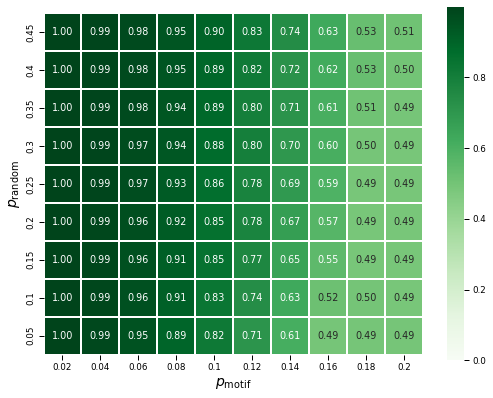

In [100]:
fig, ax = plt.subplots(figsize=(8.5, 6.5))
minpa = pd.DataFrame(minpa, index=p1, columns=p2)
sns.heatmap(minpa.T, vmin=0, cmap=colour_cmap, square=True, annot=True, fmt='.2f', linewidth=0.01)
ax.invert_yaxis()
ax.set_xlabel(r'$p_\mathregular{motif}$', fontsize=14)
ax.set_ylabel(r'$p_\mathregular{random}$', fontsize=14)
fig.savefig('../figures/minpa_heatmap.eps', format='eps', bbox_inches='tight')

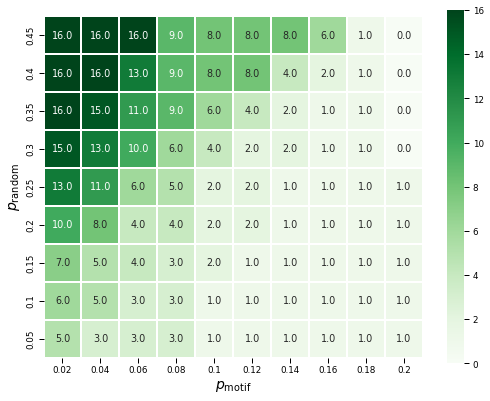

In [101]:
fig, ax = plt.subplots(figsize=(8.5, 6.5))
score_df = pd.DataFrame(scores, index=p1, columns=p2)
sns.heatmap(score_df.T, vmin=0, cmap=colour_cmap, square=True, annot=True, fmt='.1f', linewidth=0.01)
ax.invert_yaxis()
ax.set_xlabel(r'$p_\mathregular{motif}$', fontsize=14)
ax.set_ylabel(r'$p_\mathregular{random}$', fontsize=14)
fig.savefig('../figures/score_heatmap.eps', format='eps', bbox_inches='tight')

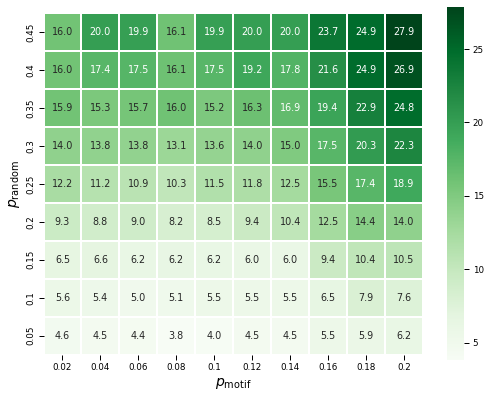

In [102]:
fig, ax = plt.subplots(figsize=(8.5, 6.5))
vol_df = pd.DataFrame(vol, index=p1, columns=p2)
sns.heatmap(vol_df.T, cmap=colour_cmap, square=True, annot=True, fmt='.1f', linewidth=0.01)
ax.invert_yaxis()
ax.set_xlabel(r'$p_\mathregular{motif}$', fontsize=14)
ax.set_ylabel(r'$p_\mathregular{random}$', fontsize=14)
fig.savefig('../figures/volume_heatmap.eps', format='eps', bbox_inches='tight')

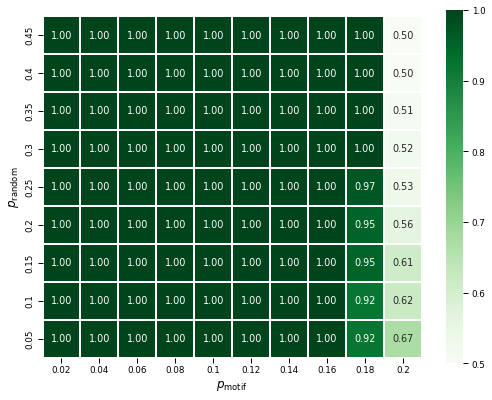

In [103]:
fig, ax = plt.subplots(figsize=(8.5, 6.5))
acc_df = pd.DataFrame(acc, index=p1, columns=p2)
sns.heatmap(acc_df.T, vmax=1, cmap=colour_cmap, square=True, annot=True, fmt='.2f', linewidth=0.01)
ax.invert_yaxis()
ax.set_xlabel(r'$p_\mathregular{motif}$', fontsize=12)
ax.set_ylabel(r'$p_\mathregular{random}$', fontsize=12)
fig.savefig('../figures/accuracy_heatmap.eps', format='eps', bbox_inches='tight')

# Certificate for best P

In [104]:
P = (0.02, 0.45)

fname = f'{P[0]}_{P[1]}_{kernel}'
votes = torch.load(f'../output/kernel/votes/{fname}').numpy()
confidence_level = 0.99

smoothed_prediction =  votes.argmax(1)
p_A = proportion_confint(votes.max(1), votes.sum(1), alpha=2 * (1-confidence_level), method='beta')[0]
abstain = p_A <= 0.5

print('p_A min', np.min(p_A))
print('abstain', np.mean(abstain))
print('Correct', np.mean(votes.argmax(1) == y_test))

p_A min 0.9984007235506814
abstain 0.0
Correct 1.0


## Averaged (main figure)

In [105]:
all_grids = []
max_R=(4, 46)
for i, p_a in enumerate(p_A):
    if not (votes.argmax(1) == y_test)[i] or abstain[i]:
        grid = np.zeros(*max_R)
    else:
        grid = certificate_grid(p_a, P, max_R)
        grid = (grid.T > 0.5).astype(float) 
        all_grids.append(grid)
grid = np.array(all_grids).mean(0)

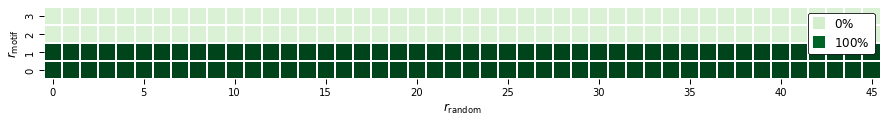

In [106]:
fig, ax = plt.subplots(figsize=(15, 1.5))

sns.heatmap(grid.T, linewidth=0.1, ax=ax, cmap=grey_cmap, vmin=-0.2, vmax=1, square=True, cbar=False)
ax.invert_yaxis()
#ax1.set_aspect('equal')
ax.tick_params(axis='both', which='major', labelsize=10)

custom_lines = [plt.Rectangle((0,0), height=20, width=20, linewidth=0, color=grey_cmap(0.2)),
                plt.Rectangle((0,0), height=20, width=20, linewidth=0, color=grey_cmap(0.9))]
ax.legend(custom_lines, ['$0\%$', r'$100\%$'], fontsize=12, framealpha=1, edgecolor='black')

ax.set_ylabel(r'$r_\mathregular{motif}$', fontsize=12)
ax.set_xlabel(r'$r_\mathregular{random}$', fontsize=12)

#ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xticks(ax.get_xticks()[::5])

fig.savefig('../figures/certificate_anis.eps', format='eps', bbox_inches='tight')

# Isotropic

In [107]:
def certificate_grid_isotropic(p_A, p, max_R):
    grid = np.zeros(max_R)
    for i in range(max_R):
        if i == 0:
            grid[i] = p_A
        else:
            grid[i] = float(isotropic(r=i, p=p, p_A=p_A))
    return grid

def evaluate_p_isotropic(p, max_R=6):
    votes = torch.load(f'../output/kernel/votes/{p}_{kernel}').numpy()
    p_A = proportion_confint(votes.max(1), votes.sum(1), alpha=2 * (1-confidence_level), method='beta')[0]
    abstain = p_A <= 0.5
    correct = votes.argmax(1) == y_test

    all_data = np.zeros((len(votes), max_R))
    for sample_idx in range(len(votes)):
        if not abstain[sample_idx] and correct[sample_idx]:
            all_data[sample_idx] = certificate_grid_isotropic(p_A[sample_idx], p, max_R)

    return all_data, abstain, correct


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

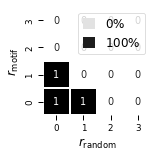

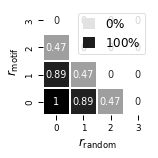

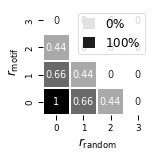

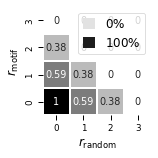

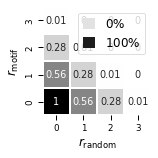

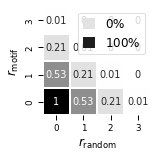

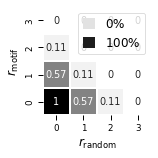

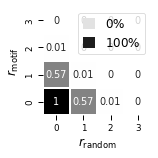

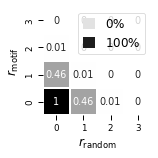

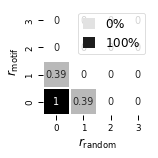

In [108]:
for p in [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]:

    fig, ax = plt.subplots(figsize=(2, 2))

    all_data, abstain, correct = evaluate_p_isotropic(p)
    all_data[np.logical_and(abstain, ~correct)] = 0.0
    all_data = np.mean(all_data > 0.5, axis=0)

    R_lim=4
    to_plot = np.zeros((R_lim, R_lim))
    for i in range(R_lim):
        for j in range(i+1):
            for k in range(i+1):
                if j + k == i:
                    to_plot[j, k] = all_data[i]




    sns.heatmap(to_plot, ax=ax, cmap='Greys', linewidth=0.01, square=True, annot=True, cbar=False)
    ax.invert_yaxis()

    custom_lines = [plt.Rectangle((0,0), height=20, width=20, linewidth=0, color=cmap(0.2)),
                    plt.Rectangle((0,0), height=20, width=20, linewidth=0, color=cmap(0.9))]
    ax.legend(custom_lines, ['$0\%$', r'$100\%$'], fontsize=12)

    ax.set_ylabel(r'$r_\mathregular{motif}$', fontsize=12)
    ax.set_xlabel(r'$r_\mathregular{random}$', fontsize=12)

    fig.savefig(f'../figures/certificate_iso_{p}.eps', format='eps', bbox_inches='tight')
    
    if p == 0.02:
        fig.savefig(f'../figures/certificate_iso.eps', format='eps', bbox_inches='tight')

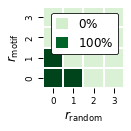

In [109]:
p = 0.02

fig, ax = plt.subplots(figsize=(1.5, 1.5))

all_data, abstain, correct = evaluate_p_isotropic(p)
all_data[np.logical_and(abstain, ~correct)] = 0.0
all_data = np.mean(all_data > 0.5, axis=0)

R_lim=4
to_plot = np.zeros((R_lim, R_lim))
for i in range(R_lim):
    for j in range(i+1):
        for k in range(i+1):
            if j + k == i:
                to_plot[j, k] = all_data[i]


sns.heatmap(to_plot, ax=ax, cmap=grey_cmap, linewidth=0.01, vmin=-0.2, square=True, annot=False, cbar=False)
ax.invert_yaxis()

custom_lines = [plt.Rectangle((0,0), height=20, width=20, linewidth=0, color=grey_cmap(0.2)),
                plt.Rectangle((0,0), height=20, width=20, linewidth=0, color=grey_cmap(0.9))]
ax.legend(custom_lines, ['$0\%$', r'$100\%$'], fontsize=12, framealpha=1, edgecolor='black')


ax.set_ylabel(r'$r_\mathregular{motif}$', fontsize=12)
ax.set_xlabel(r'$r_\mathregular{random}$', fontsize=12)

fig.savefig(f'../figures/certificate_iso_{p}.eps', format='eps', bbox_inches='tight')

if p == 0.02:
    fig.savefig(f'../figures/certificate_iso.eps', format='eps', bbox_inches='tight')

In [57]:
to_plot

array([[1.  , 0.39, 0.  , 0.  ],
       [0.39, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  ]])

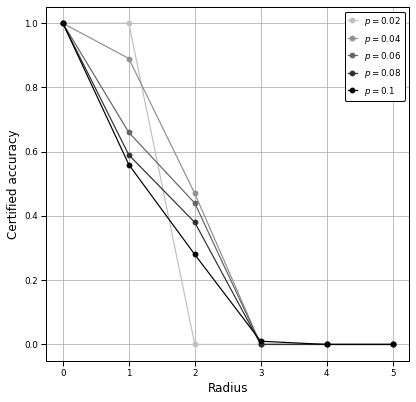

In [58]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))
cmap = cm.Greys

for p in [0.02, 0.04, 0.06, 0.08, 0.1]:
    all_data, abstain, correct = evaluate_p_isotropic(p)
    all_data[np.logical_and(abstain, ~correct)] = 0.0
    ax.plot(np.mean(all_data > 0.5, axis=0), label=f'$p={p}$', color=cmap(0.2 + p*8), marker="o")
ax.grid()

#ax.yaxis.set_ticks(np.arange(0, 1.01, 0.1))
#ax.xaxis.set_ticks(np.arange(0, 11, 1))

legend = ax.legend(framealpha=1.)
legend.get_frame().set_linewidth(1)
legend.get_frame().set_edgecolor("black")

ax.set_xlabel('Radius', fontsize=12)
ax.set_ylabel('Certified accuracy', fontsize=12)

fig.savefig('../figures/certificate_iso.eps', format='eps', bbox_inches='tight')